In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

In [2]:
def reduce_mem_usage(df):
    """ 
    Iterate through all the columns of a dataframe 
    and modify the data type to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [54]:
train_i = pd.read_csv('/Users/feihuyan/Downloads/ieee-fraud-detection/train_identity.csv')
train_t = pd.read_csv('/Users/feihuyan/Downloads/ieee-fraud-detection/train_transaction.csv')
test_i = pd.read_csv('/Users/feihuyan/Downloads/ieee-fraud-detection/test_identity.csv')
test_t = pd.read_csv('/Users/feihuyan/Downloads/ieee-fraud-detection/test_transaction.csv')
samp_sub = pd.read_csv('/Users/feihuyan/Downloads/ieee-fraud-detection/sample_submission.csv')

In [55]:
train_t.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [56]:
train_i.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


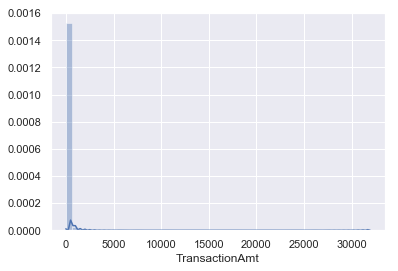

In [57]:
sns.distplot(train_t['TransactionAmt'])

In [58]:
train_t['TransactionAmt_Log'] = np.log(train_t['TransactionAmt'])
test_t['TransactionAmt_Log'] = np.log(test_t['TransactionAmt'])

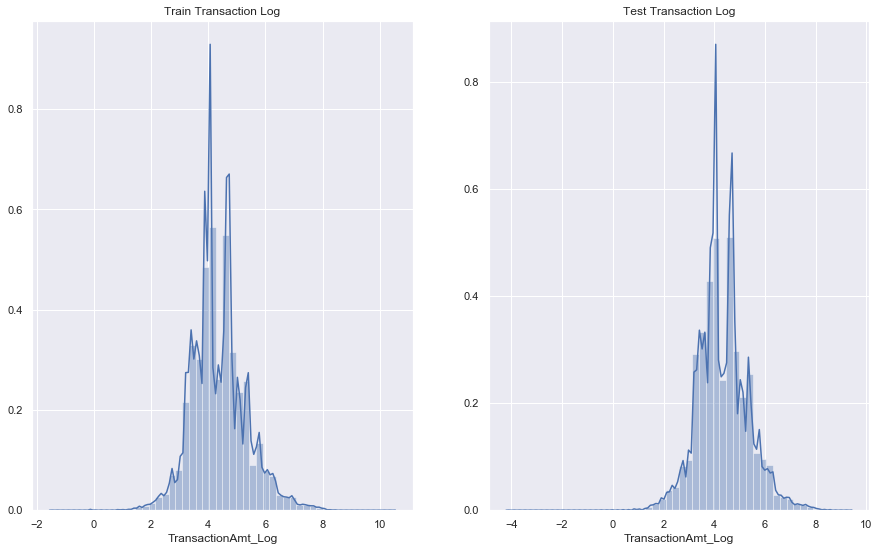

In [59]:
f,ax = plt.subplots(1, 2, figsize=(15,9))
sns.distplot(train_t['TransactionAmt_Log'], ax=ax[0]).set_title("Train Transaction Log")
sns.distplot(test_t['TransactionAmt_Log'], ax=ax[1]).set_title("Test Transaction Log")
plt.show()

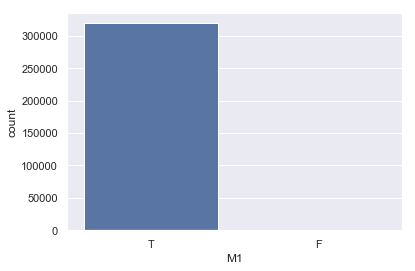

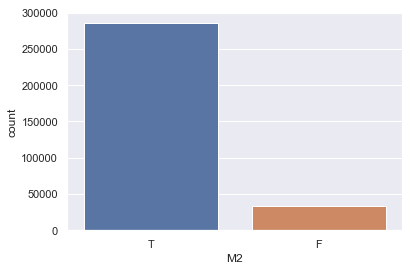

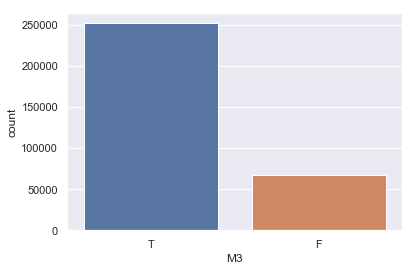

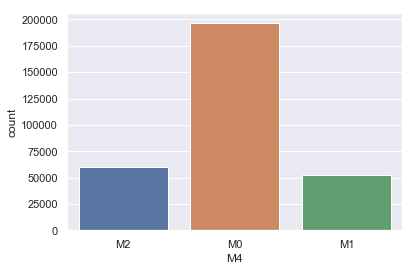

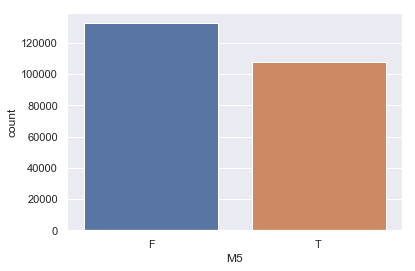

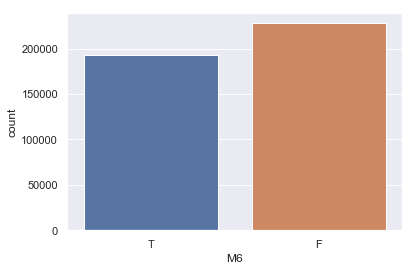

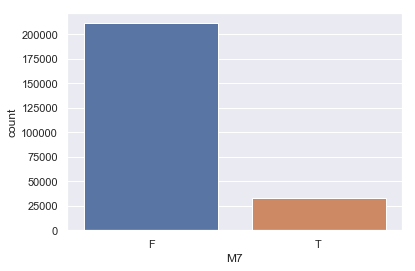

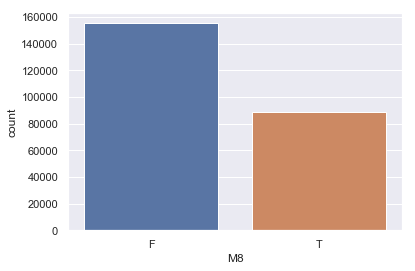

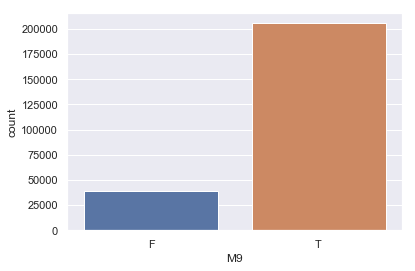

In [60]:
for i in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    plt.figure()
    sns.countplot(x=train_t[i])
plt.show()

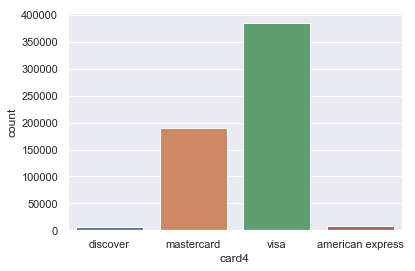

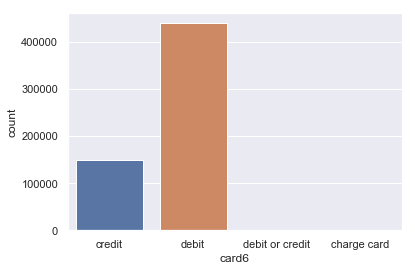

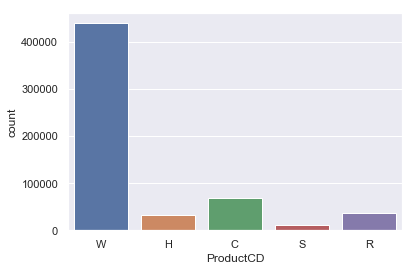

In [61]:
for col in ['card4','card6','ProductCD']:
    plt.figure()
    sns.countplot(x=train_t[col])
plt.show()

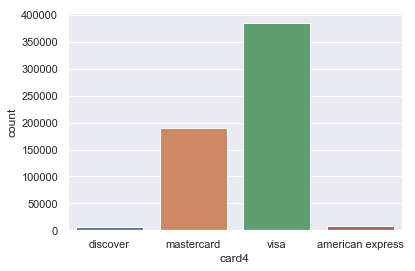

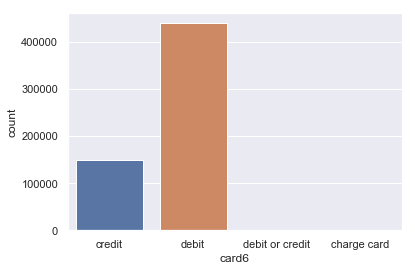

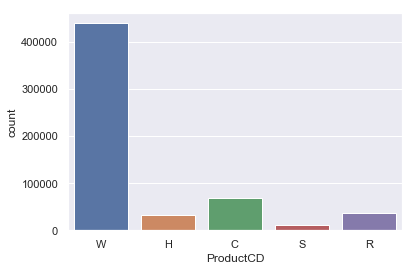

In [62]:
for col in ['card4','card6','ProductCD']:
    plt.figure()
    sns.countplot(x=train_t[col])
plt.show()

In [63]:
set(train_i.DeviceInfo.values)

{nan,
 'MYA-L23',
 'P00C',
 'A96 Build/LMY47I',
 'KFFOWI Build/LVY48F',
 'SM-J327VPP Build/NRD90M',
 'BBB100-2',
 'SLA-L02',
 'SM-J200M Build/LMY47X',
 'Moto',
 'SM-A500M Build/KTU84P',
 'SM-G9250',
 'HTCD200LVW',
 'SM-T817T',
 'SM-P580 Build/NRD90M',
 'SM-T705',
 'SM-G900V',
 'WAS-LX1A Build/HUAWEIWAS-LX1A',
 'Pixel Build/OPM2.171019.029',
 'G3313',
 'Pixel 2 Build/OPM2.171019.016',
 'VS5012 Build/NRD90M',
 'BV7000',
 'GRACE',
 'verykools5004',
 'rv:55.0',
 'SAMSUNG SM-G920F Build/LRX22G',
 'E6603',
 'TA-1003',
 'SAMSUNG SM-G950U1 Build/NRD90M',
 'HUAWEI CAN-L11 Build/HUAWEICAN-L11',
 'D5316 Build/19.4.A.0.182',
 'verykoolS5524',
 'SM-G930T1',
 'SC-02H',
 'SM-E500M Build/KTU84P',
 'TR10CS1 Build/JDQ39',
 'SM-G570M Build/MMB29K',
 'SAMSUNG-SM-T807A',
 'LG-K450 Build/MXB48T',
 'SAMSUNG SM-N950U1 Build/R16NW',
 'LGMS345',
 'SM-A510F Build/MMB29K',
 'Nexus 5 Build/M4B30Z',
 'F1f Build/LMY47V',
 'ONE A2005 Build/MMB29M',
 'SAMSUNG-SM-G900A Build/LMY47X',
 'HTC One_M8 Build/MRA58K',
 'SM-J3

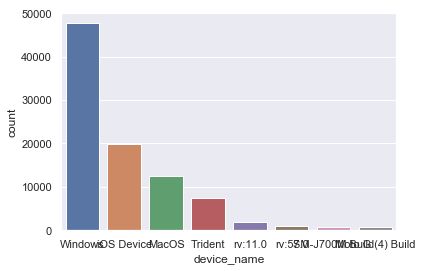

In [64]:
train_i['device_name'] = train_i['DeviceInfo'].str.split('/', expand=True)[0]
sns.countplot(x=train_i['device_name'],
                  order=pd.value_counts(train_i['device_name']).iloc[:8].index)

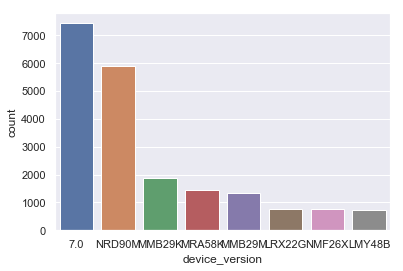

In [65]:
train_i['device_version'] = train_i['DeviceInfo'].str.split('/', expand=True)[1]
sns.countplot(x=train_i['device_version'],
                  order=pd.value_counts(train_i['device_version']).iloc[:8].index)

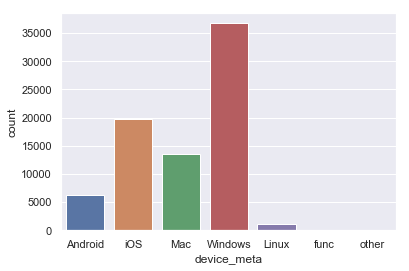

In [66]:
train_i['device_meta'] = train_i['id_30'].str.split(' ', expand=True)[0]
sns.countplot(x=train_i['device_meta'])

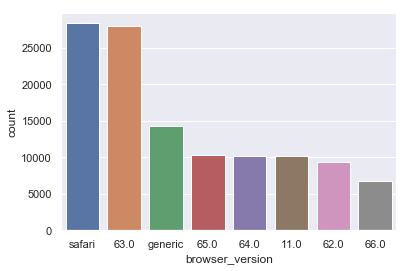

In [67]:
train_i['browser_version'] = train_i['id_31'].str.split(' ', expand=True)[1]
sns.countplot(x=train_i['browser_version'],
                  order=pd.value_counts(train_i['browser_version']).iloc[:8].index)

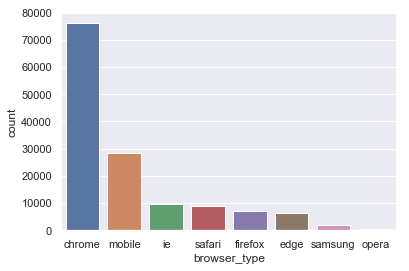

In [68]:
train_i['browser_type'] = train_i['id_31'].str.split(' ', expand=True)[0]
sns.countplot(x=train_i['browser_type'],
                  order=pd.value_counts(train_i['browser_type']).iloc[:8].index)

In [69]:
train_i['device_n'] = train_i['id_30'].str.split(' ', expand=True)[1]
train_i.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,device_name,device_version,device_meta,browser_version,browser_type,device_n
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,SAMSUNG SM-G892A Build,NRD90M,Android,browser,samsung,7.0
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device,iOS Device,None,iOS,safari,mobile,11.1.2
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows,Windows,None,NaN,62.0,chrome,NaN
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN,NaN,NaN,NaN,62.0,chrome,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS,MacOS,None,Mac,62.0,chrome,OS


In [70]:
print(set(train_i.id_23.values))
print(set(train_i.id_34.values))

{nan, 'IP_PROXY:TRANSPARENT', 'IP_PROXY:HIDDEN', 'IP_PROXY:ANONYMOUS'}
{nan, 'match_status:2', 'match_status:1', 'match_status:-1', 'match_status:0'}


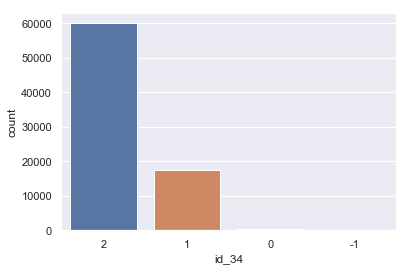

In [71]:
train_i['id_34'] = train_i['id_34'].str.split(':', expand=True)[1]
sns.countplot(train_i['id_34'])

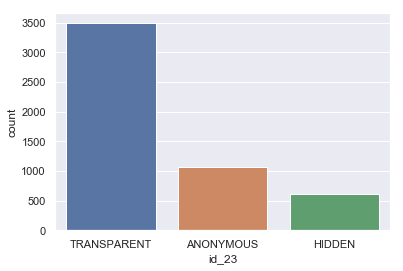

In [72]:
train_i['id_23'] = train_i['id_23'].str.split(':', expand=True)[1]
sns.countplot(train_i['id_23'])

In [73]:
print(set(train_i.device_name.values))

{nan, 'MYA-L23', 'MOT-A6020l37 Build', 'KFAPWI Build', 'P00C', 'BBB100-2', 'SLA-L02', 'SAMSUNG SM-G965F Build', 'Moto', 'SM-J727VPP Build', 'SM-G9250', 'HTCD200LVW', 'SM-T817T', 'SM-T705', 'SM-G900V', 'G3313', 'Moto G (5) Plus Build', 'XT1609 Build', 'BV7000', 'GRACE', 'SM-T800 Build', 'Ilium X510 Build', 'SAMSUNG-SM-G920A Build', 'verykools5004', 'rv:55.0', 'GT-I8190L Build', 'E6603', 'LG-K450 Build', 'TA-1003', 'QTAIR7 Build', 'SM-G935T Build', 'Ilium LT520 Build', 'verykoolS5524', 'MotoG3 Build', 'SM-G930T1', 'M4 SS4456 Build', 'SC-02H', 'SAMSUNG-SM-G530AZ Build', 'SAMSUNG-SM-T807A', 'RNE-L22 Build', 'SM-G610F Build', 'LGMP260 Build', 'SAMSUNG SM-G920F Build', 'C6743 Build', 'LGMS345', '9008A Build', 'SAMSUNG SM-J320F Build', 'SM-J330F', 'Ilium L1000 Build', 'Moto Z2 Play Build', 'SM-T530', 'Neffos X1 Max Build', 'SM-J500FN', 'LG-V521', 'H3321', 'K10', '9003A Build', 'verykoolS5525', 'R2', 'G630-U251', 'SAMSUNG SM-G960U Build', 'SM-P355M', 'WOW64', 'F3111 Build', 'QTASUN1 Build', 'R

In [74]:
def brand_conversion(df):
    df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    df.loc[df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    df.loc[df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'
    df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    df['had_id'] = 1
    return df

In [75]:
train_i_1 = brand_conversion(train_i)

In [76]:
test_i['device_name'] = test_i['DeviceInfo'].str.split('/', expand=True)[0]
test_i['device_version'] = test_i['DeviceInfo'].str.split('/', expand=True)[1]
test_i['device_meta'] = test_i['id-30'].str.split(' ', expand=True)[0]
test_i['device_n'] = test_i['id-30'].str.split(' ', expand=True)[1]
test_i['browser_type'] = test_i['id-31'].str.split(' ', expand=True)[0]
test_i['browser_version'] = test_i['id-31'].str.split(' ', expand=True)[1]
test_i['id-34'] = test_i['id-34'].str.split(':', expand=True)[1]
test_i['id-23'] = test_i['id-23'].str.split(':', expand=True)[1]

test_i_1 = brand_conversion(test_i)

In [91]:
test_i.rename(columns={'id-01':'id_01', 
                   'id-02':'id_02',
                   'id-03':'id_03', 
                   'id-04':'id_04',
                   'id-05':'id_05', 
                   'id-06':'id_06',
                   'id-07':'id_07', 
                   'id-08':'id_08',
                   'id-09':'id_09', 
                   'id-10':'id_10',
                   'id-11':'id_11', 
                   'id-12':'id_12',
                   'id-13':'id_13',
                   'id-14':'id_14',
                   'id-15':'id_15',
                   'id-16':'id_16',
                   'id-17':'id_17', 
                   'id-18':'id_18',
                   'id-19':'id_19', 
                   'id-20':'id_20',
                   'id-21':'id_21', 
                   'id-22':'id_22',
                   'id-23':'id_23', 
                   'id-24':'id_24',
                   'id-25':'id_25', 
                   'id-26':'id_26',
                   'id-27':'id_27', 
                   'id-28':'id_28',
                   'id-29':'id_29', 
                   'id-30':'id_30',
                   'id-31':'id_31', 
                   'id-32':'id_32',
                   'id-33':'id_33', 
                   'id-34':'id_34',
                   'id-35':'id_35', 
                   'id-36':'id_36',
                   'id-37':'id_37',
                   'id-38':'id_38'}, inplace=True)

In [92]:
train_df = train_t.merge(train_i_1, how='left', left_index=True, right_index=True)
test_df = test_t.merge(test_i_1, how='left', left_index=True, right_index=True)

In [93]:
pd.set_option("display.max_columns", None)
train_df.head()

,TransactionID_x,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,TransactionAmt_Log,TransactionID_y,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,device_name,device_version,device_meta,browser_version,browser_type,device_n,had_id
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.226834,2987004.0,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,An

In [94]:
features_to_use = ['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
                   'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
                   'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M2', 'M3',
                   'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V17',
                   'V19', 'V20', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V44', 'V45', 'V46', 'V47', 'V48',
                   'V49', 'V51', 'V52', 'V53', 'V54', 'V56', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 'V71',
                   'V72', 'V73', 'V74', 'V75', 'V76', 'V78', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V92',
                   'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V138', 'V139', 'V140',
                   'V143', 'V145', 'V146', 'V147', 'V149', 'V150', 'V151', 'V152', 'V154', 'V156', 'V158', 'V159', 'V160', 'V161',
                   'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V169', 'V170', 'V171', 'V172', 'V173', 'V175', 'V176', 'V177',
                   'V178', 'V180', 'V182', 'V184', 'V187', 'V188', 'V189', 'V195', 'V197', 'V200', 'V201', 'V202', 'V203', 'V204',
                   'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V219', 'V220',
                   'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V231', 'V233', 'V234', 'V238', 'V239',
                   'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V249', 'V251', 'V253', 'V256', 'V257', 'V258', 'V259', 'V261',
                   'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276',
                   'V277', 'V278', 'V279', 'V280', 'V282', 'V283', 'V285', 'V287', 'V288', 'V289', 'V291', 'V292', 'V294', 'V303',
                   'V304', 'V306', 'V307', 'V308', 'V310', 'V312', 'V313', 'V314', 'V315', 'V317', 'V322', 'V323', 'V324', 'V326',
                   'V329', 'V331', 'V332', 'V333', 'V335', 'V336', 'V338', 'id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_09',
                   'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_32', 'id_33',
                   'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'device_name', 'device_version', 'OS_id_30', 'version_id_30',
                   'browser_id_31', 'version_id_31', 'screen_width', 'screen_height', 'had_id', 'TransactionAmt_Log']
cols_to_drop = [col for col in train_df.columns if col not in features_to_use]
cols_to_drop.remove('isFraud')
cols_to_drop.remove('TransactionDT')

In [95]:
train_df = train_df.drop(cols_to_drop, axis=1)
test_df = test_df.drop(cols_to_drop, axis=1)

In [96]:
train_df['TransactionAmt_decimal'] = ((train_df['TransactionAmt'] - train_df['TransactionAmt'].astype(int)) * 1000).astype(int)
test_df['TransactionAmt_decimal'] = ((test_df['TransactionAmt'] - test_df['TransactionAmt'].astype(int)) * 1000).astype(int)

In [97]:
train_df['Transaction_day_of_week'] = np.floor((train_df['TransactionDT'] / (3600 * 24) - 1) % 7)
test_df['Transaction_day_of_week'] = np.floor((test_df['TransactionDT'] / (3600 * 24) - 1) % 7)

In [98]:
train_df['Transaction_hour'] = np.floor(train_df['TransactionDT'] / 3600) % 24
test_df['Transaction_hour'] = np.floor(test_df['TransactionDT'] / 3600) % 24

In [99]:
columns_a = ['TransactionAmt', 'id_02', 'D15']
columns_b = ['card1', 'card4', 'addr1']

for col_a in columns_a:
    for col_b in columns_b:
        for df in [train_df, test_df]:
            df[f'{col_a}_to_mean_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].transform('mean')
            df[f'{col_a}_to_std_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].transform('std')

In [100]:
for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'P_emaildomain__C2', 
                'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']:
    f1, f2 = feature.split('__')
    train_df[feature] = train_df[f1].astype(str) + '_' + train_df[f2].astype(str)
    test_df[feature] = test_df[f1].astype(str) + '_' + test_df[f2].astype(str)

    le = LabelEncoder()
    le.fit(list(train_df[feature].astype(str).values) + list(test_df[feature].astype(str).values))
    train_df[feature] = le.transform(list(train_df[feature].astype(str).values))
    test_df[feature] = le.transform(list(test_df[feature].astype(str).values))

#Encoding - count encoding for both train and test
for feature in ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'id_36']:
    train_df[feature + '_count_full'] = train_df[feature].map(pd.concat([train_df[feature], test_df[feature]], ignore_index=True).value_counts(dropna=False))
    test_df[feature + '_count_full'] = test_df[feature].map(pd.concat([train_df[feature], test_df[feature]], ignore_index=True).value_counts(dropna=False))

#Encoding - count encoding separately for train and test
for feature in ['id_01', 'id_31', 'id_33', 'id_36']:
    train_df[feature + '_count_dist'] = train_df[feature].map(train_df[feature].value_counts(dropna=False))
    test_df[feature + '_count_dist'] = test_df[feature].map(test_df[feature].value_counts(dropna=False))

In [101]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

In [102]:
for c in ['P_emaildomain', 'R_emaildomain']:
    train_df[c + '_bin'] = train_df[c].map(emails)
    test_df[c + '_bin'] = test_df[c].map(emails)
    
    train_df[c + '_suffix'] = train_df[c].map(lambda x: str(x).split('.')[-1])
    test_df[c + '_suffix'] = test_df[c].map(lambda x: str(x).split('.')[-1])
    
    train_df[c + '_suffix'] = train_df[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test_df[c + '_suffix'] = test_df[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [103]:
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train_df[col].astype(str).values) + list(test_df[col].astype(str).values))
        train_df[col] = le.transform(list(train_df[col].astype(str).values))
        test_df[col] = le.transform(list(test_df[col].astype(str).values))

In [104]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 1491.31 MB
Memory usage after optimization is: 422.39 MB
Decreased by 71.7%
Memory usage of dataframe is 1275.70 MB
Memory usage after optimization is: 369.66 MB
Decreased by 71.0%


In [105]:
X = train_df.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT'], axis=1)
y = train_df.sort_values('TransactionDT')['isFraud']

X_test = test_df.drop(['TransactionDT'], axis=1)

In [106]:
from sklearn.model_selection import KFold
import lightgbm as lgb

In [107]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
         }

In [108]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS)

columns = X.columns
splits = folds.split(X, y)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X.shape[0])
score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += clf.predict(X_test) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")

Training until validation scores don't improve for 500 rounds
[200]	training's auc: 0.956119	valid_1's auc: 0.89091
[400]	training's auc: 0.976904	valid_1's auc: 0.904435
[600]	training's auc: 0.988209	valid_1's auc: 0.912443
[800]	training's auc: 0.99398	valid_1's auc: 0.916782
[1000]	training's auc: 0.996876	valid_1's auc: 0.91935
[1200]	training's auc: 0.99828	valid_1's auc: 0.920501
[1400]	training's auc: 0.999012	valid_1's auc: 0.920699
[1600]	training's auc: 0.999425	valid_1's auc: 0.920691
[1800]	training's auc: 0.999665	valid_1's auc: 0.920559
Early stopping, best iteration is:
[1415]	training's auc: 0.999049	valid_1's auc: 0.920753
Fold 1 | AUC: 0.9207531197107687
Training until validation scores don't improve for 500 rounds
[200]	training's auc: 0.955953	valid_1's auc: 0.912202
[400]	training's auc: 0.977554	valid_1's auc: 0.923802
[600]	training's auc: 0.989572	valid_1's auc: 0.93132
[800]	training's auc: 0.995288	valid_1's auc: 0.934909
[1000]	training's auc: 0.997788	valid

In [109]:
samp_sub['isFraud'] = y_preds
samp_sub.to_csv("submission.csv", index=False)

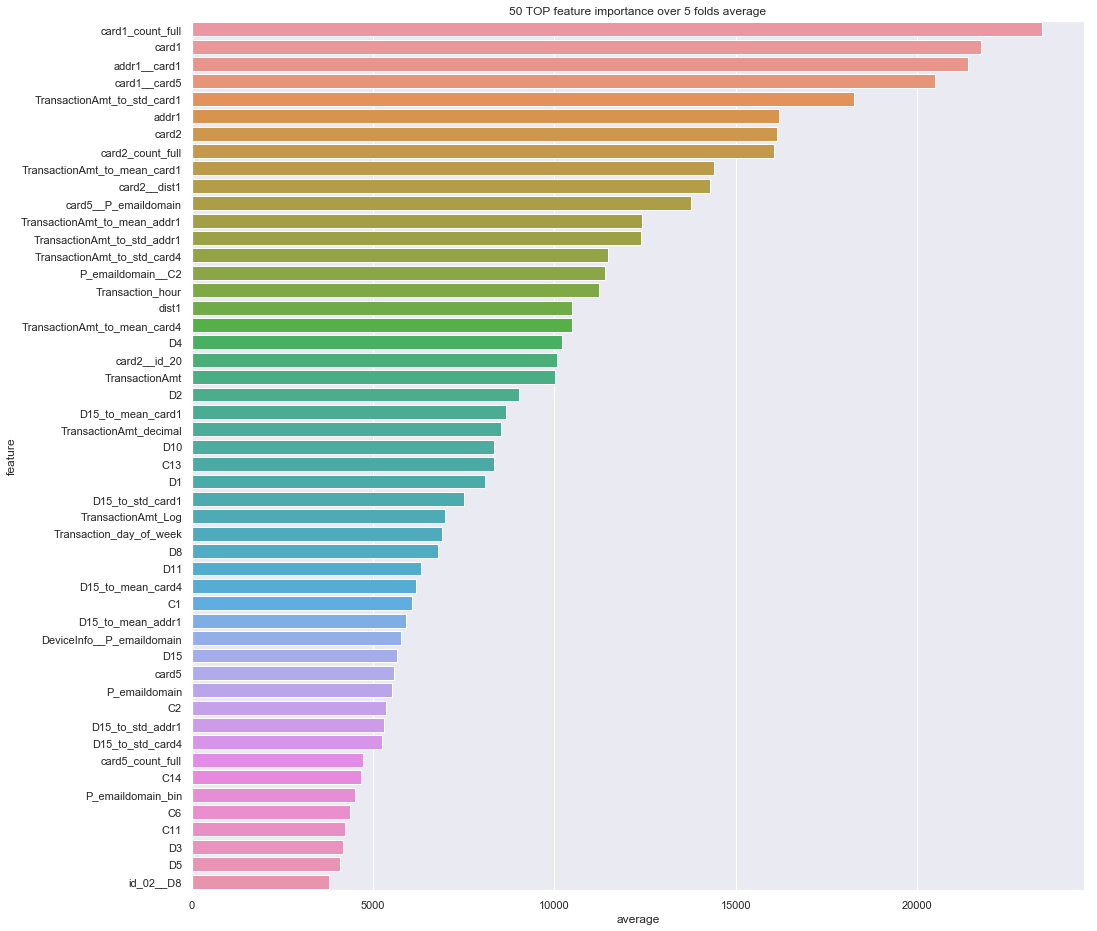

In [110]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));